# Multi-Class Image Classification Deep Learning Model for Colorectal Cancer Histology Using TensorFlow Take 1
### David Lowe
### November 26, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Colorectal Cancer Histology dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

In this Take1 iteration, we will construct several simple three-layer CNN's to model the dataset. We will use the best network as the baseline model for future modeling iterations.

INTRODUCTION: This data set represents a collection of textures in histological images of human colorectal cancer. All images are RGB, 0.495 µm per pixel, digitized with an Aperio ScanScope (Aperio/Leica biosystems), magnification 20x. The histological samples contain fully anonymized images of formalin-fixed paraffin-embedded human colorectal adenocarcinomas (primary tumors) from our pathology archive (Institute of Pathology, University Medical Center Mannheim, Heidelberg University, Mannheim, Germany).

ANALYSIS: The baseline model's performance achieved an accuracy score of 98.25% after 15 epochs using the training dataset. After tuning the hyperparameters, the best model processed the validation dataset with an accuracy score of 84.00%.

CONCLUSION: In this iteration, the TensorFlow CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: Colorectal Cancer Histology Dataset, Kather JN, Weis CA, Bianconi F, Melchers SM, Schad LR, Gaiser T, Marx A, Zollner F: Multi-class texture analysis in colorectal cancer histology (2016), Scientific Reports (in press)

Dataset ML Model: Multi-class image classification with numerical attributes

Dataset Reference: https://zenodo.org/record/53169#.XGZemKwzbmG

One potential source of performance benchmarks: https://www.kaggle.com/kmader/colorectal-histology-mnist

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
!pip install python-dotenv PyMySQL

     |████████████████████████████████| 51kB 4.6MB/s 


In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Nov 17 18:56:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# # Direct Colab to use TensorFlow v2
# %tensorflow_version 2.x

In [5]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


## 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
seedNum = 888

In [7]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
# import boto3
# import zipfile
from datetime import datetime
from dotenv import load_dotenv
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [8]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
VAL_SET_SIZE = 0.2

# Set various default modeling parameters
default_loss = 'categorical_crossentropy'
default_metrics = ['accuracy']
default_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.keras.initializers.GlorotUniform(seed=seedNum)
EPOCH_NUMBER = 15
BATCH_SIZE = 16
IMAGE_SIZE = (150, 150)
input_image_shape = (150, 150, 3)
num_classes = 8

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.3.0


In [9]:
# Set up the parent directory location for loading the dotenv files
# useColab = True
# if useColab:
#     # Mount Google Drive locally for storing files
#     from google.colab import drive
#     drive.mount('/content/gdrive')
#     gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
#     env_path = '/content/gdrive/My Drive/Colab Notebooks/'
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# useLocalPC = True
# if useLocalPC:
#     env_path = "/Users/david/PycharmProjects/"
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

In [10]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [11]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [12]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [13]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [14]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [15]:
# Clean up the old files and download directories before receiving new ones
!rm -rf staging/

In [16]:
staging_dir = 'staging/'
!mkdir staging/

In [17]:
data_dir = keras.utils.get_file(
    'Kather_texture_2016_image_tiles_5000.zip',
    'https://dainesanalytics.com/datasets/tensorflow-colorectal-cancer-histology/Kather_texture_2016_image_tiles_5000.zip',
    cache_subdir='/content/staging',
    extract=True)

258105344/258098431 [==============================] - 4s 0us/step


In [18]:
data_dir = 'staging/Kather_texture_2016_image_tiles_5000/'
class1_name = '01_TUMOR'
class2_name = '02_STROMA'
class3_name = '03_COMPLEX'
class4_name = '04_LYMPHO'
class5_name = '05_DEBRIS'
class6_name = '06_MUCOSA'
class7_name = '07_ADIPOSE'
class8_name = '08_EMPTY'

In [19]:
# Brief listing of training image files for class 1
training_class1_dir = os.path.join(data_dir, class1_name)
training_class1_files = os.listdir(training_class1_dir)
print('Number of training images for', class1_name, ':', len(os.listdir(training_class1_dir)))
print('Training samples for', class1_name, ':', training_class1_files[:10])

# Brief listing of training image files for class 2
training_class2_dir = os.path.join(data_dir, class2_name)
training_class2_files = os.listdir(training_class2_dir)
print('Number of training images for', class2_name, ':', len(os.listdir(training_class2_dir)))
print('Training samples for', class2_name, ':', training_class2_files[:10])

# Brief listing of training image files for class 3
training_class3_dir = os.path.join(data_dir, class3_name)
training_class3_files = os.listdir(training_class3_dir)
print('Number of training images for', class3_name, ':', len(os.listdir(training_class3_dir)))
print('Training samples for', class3_name, ':', training_class3_files[:10])

training_class4_dir = os.path.join(data_dir, class4_name)
training_class4_files = os.listdir(training_class4_dir)
print('Number of training images for', class4_name, ':', len(os.listdir(training_class4_dir)))
print('Training samples for', class4_name, ':', training_class4_files[:10])

training_class5_dir = os.path.join(data_dir, class5_name)
training_class5_files = os.listdir(training_class5_dir)
print('Number of training images for', class5_name, ':', len(os.listdir(training_class5_dir)))
print('Training samples for', class5_name, ':', training_class5_files[:10])

training_class6_dir = os.path.join(data_dir, class6_name)
training_class6_files = os.listdir(training_class6_dir)
print('Number of training images for', class6_name, ':', len(os.listdir(training_class6_dir)))
print('Training samples for', class6_name, ':', training_class6_files[:10])

training_class7_dir = os.path.join(data_dir, class7_name)
training_class7_files = os.listdir(training_class7_dir)
print('Number of training images for', class7_name, ':', len(os.listdir(training_class7_dir)))
print('Training samples for', class7_name, ':', training_class7_files[:10])

training_class8_dir = os.path.join(data_dir, class8_name)
training_class8_files = os.listdir(training_class8_dir)
print('Number of training images for', class8_name, ':', len(os.listdir(training_class8_dir)))
print('Training samples for', class8_name, ':', training_class8_files[:10])

Number of training images for 01_TUMOR : 625
Training samples for 01_TUMOR : ['19C8_CRC-Prim-HE-07.tif_Row_601_Col_1.tif', '1618A_CRC-Prim-HE-07_025.tif_Row_751_Col_301.tif', '18034_CRC-Prim-HE-08_007.tif_Row_1351_Col_1.tif', '16AD0_CRC-Prim-HE-01_046.tif_Row_1_Col_151.tif', '11B32_CRC-Prim-HE-07.tif_Row_1_Col_301.tif', '10B79_CRC-Prim-HE-05_013.tif_Row_1_Col_301.tif', '15FD9_CRC-Prim-HE-08_007.tif_Row_1051_Col_301.tif', '1DAD_CRC-Prim-HE-07_022.tif_Row_1_Col_1.tif', '7453_CRC-Prim-HE-08_016.tif_Row_1_Col_451.tif', '165B6_CRC-Prim-HE-01_032.tif_Row_1_Col_1.tif']
Number of training images for 02_STROMA : 625
Training samples for 02_STROMA : ['10202_CRC-Prim-HE-02_011.tif_Row_451_Col_1.tif', '12A69_CRC-Prim-HE-03_030.tif_Row_601_Col_1.tif', '10E1D_CRC-Prim-HE-08_004.tif_Row_1201_Col_451.tif', '1262E_CRC-Prim-HE-04_013.tif_Row_2701_Col_1.tif', '1438F_CRC-Prim-HE-03_003.tif_Row_301_Col_751.tif', '11751_CRC-Prim-HE-03.tif_Row_1051_Col_1501.tif', '10310_CRC-Prim-HE-04.tif_Row_1951_Col_151.ti

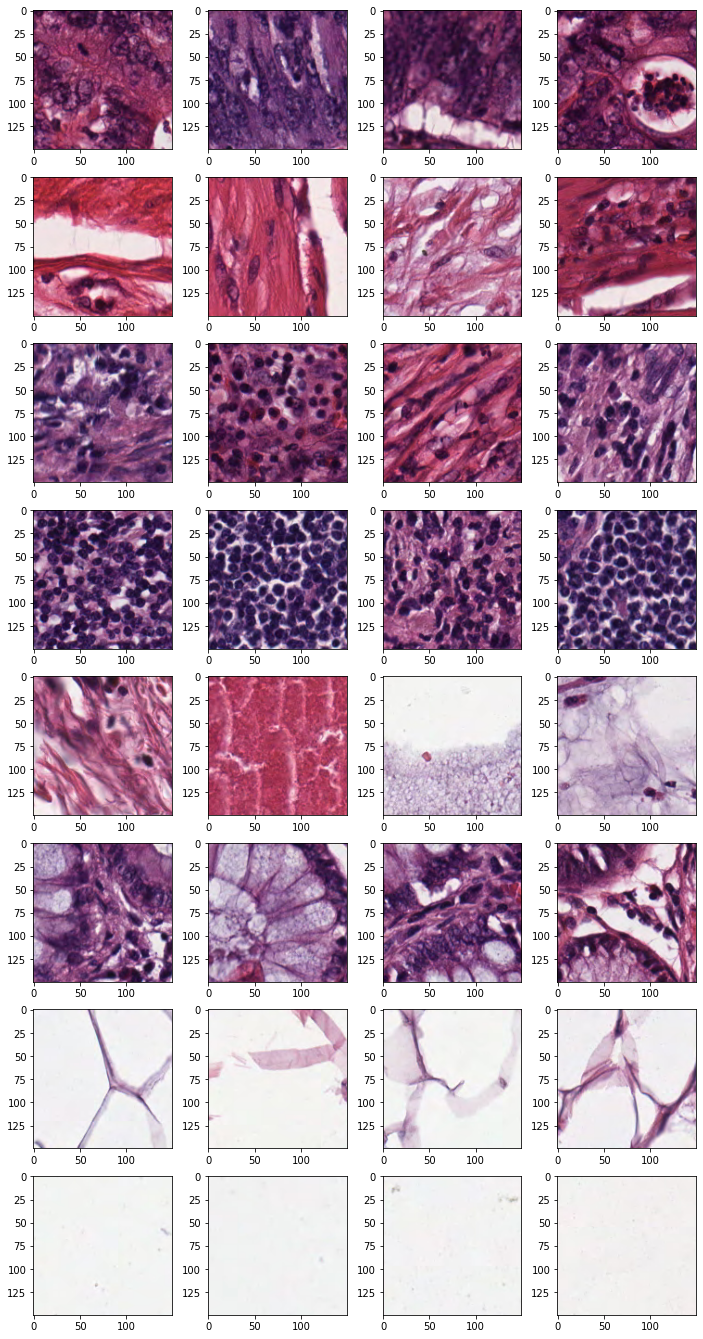

In [20]:
# Plot some training images from the dataset
nrows = 8
ncols = 4

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

reset_random(seedNum)
number_elements = ncols
random_training_class1 = random.sample(training_class1_files, number_elements)
random_training_class2 = random.sample(training_class2_files, number_elements)
random_training_class3 = random.sample(training_class3_files, number_elements)
random_training_class4 = random.sample(training_class4_files, number_elements)
random_training_class5 = random.sample(training_class5_files, number_elements)
random_training_class6 = random.sample(training_class6_files, number_elements)
random_training_class7 = random.sample(training_class7_files, number_elements)
random_training_class8 = random.sample(training_class8_files, number_elements)
next_class1 = [os.path.join(training_class1_dir, fname) for fname in random_training_class1]
next_class2 = [os.path.join(training_class2_dir, fname) for fname in random_training_class2]
next_class3 = [os.path.join(training_class3_dir, fname) for fname in random_training_class3]
next_class4 = [os.path.join(training_class4_dir, fname) for fname in random_training_class4]
next_class5 = [os.path.join(training_class5_dir, fname) for fname in random_training_class5]
next_class6 = [os.path.join(training_class6_dir, fname) for fname in random_training_class6]
next_class7 = [os.path.join(training_class7_dir, fname) for fname in random_training_class7]
next_class8 = [os.path.join(training_class8_dir, fname) for fname in random_training_class8]

for i, img_path in enumerate(next_class1 + next_class2 + next_class3 + next_class4 + next_class5 + next_class6 + next_class7 + next_class8):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
#     sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

In [21]:
datagen_kwargs = dict(rescale=1./255, validation_split=VAL_SET_SIZE)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

print('Loading and pre-processing the validation images...')
validation_datagen = ImageDataGenerator(**datagen_kwargs)
validation_generator = validation_datagen.flow_from_directory(data_dir, subset="validation", shuffle=False, **dataflow_kwargs)
print('Number of image batches per epoch of modeling:', len(validation_generator))

do_data_augmentation = False 
if do_data_augmentation:
    training_datagen = ImageDataGenerator(
        rotation_range=45,
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        **datagen_kwargs)
else:
    training_datagen = validation_datagen

print('\nLoading and pre-processing the training images...')
training_generator = training_datagen.flow_from_directory(data_dir, subset="training", shuffle=True, **dataflow_kwargs)
print('Number of image batches per epoch of modeling:', len(training_generator))

Loading and pre-processing the validation images...
Found 1000 images belonging to 8 classes.
Number of image batches per epoch of modeling: 63

Loading and pre-processing the training images...
Found 4000 images belonging to 8 classes.
Number of image batches per epoch of modeling: 250


In [22]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [23]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [24]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.legend()

In [25]:
# Define the baseline model for benchmarking
def create_nn_model(conv1_filters=192, conv2_filters=128, conv3_filters=64, conv1_dropout=0.25, conv2_dropout=0.25, conv3_dropout=0, dense_nodes=512, dense_dropout=0.25,
                    n_inputs=input_image_shape, n_outputs=num_classes, opt_param=default_optimizer, init_param=default_kernel_init):
    nn_model = keras.Sequential([
        # This is the first convolution
        keras.layers.Conv2D(conv1_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param, input_shape=n_inputs),
        keras.layers.Dropout(conv1_dropout),
        # keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2), strides=2,  padding='same'),
        # This is the second convolution
        keras.layers.Conv2D(conv2_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(conv2_dropout),
        # keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2), strides=2,  padding='same'),
        # This is the third convolution
        keras.layers.Conv2D(conv3_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(conv3_dropout),
        # keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2), strides=2,  padding='same'),
        # Flatten the results to feed into a DNN
        # This is the last neuron hidden layer
        keras.layers.Flatten(),
        keras.layers.Dense(dense_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(dense_dropout),
        keras.layers.Dense(n_outputs, activation='softmax', kernel_initializer=init_param)
    ])
    nn_model.compile(loss=default_loss, optimizer=opt_param, metrics=default_metrics)
    return nn_model

In [26]:
# Initialize the neural network model and get the training results for plotting graph
startTimeModule = datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.5, min_lr=0.00001)
reset_random(seedNum)
nn_model_0 = create_nn_model()
nn_model_history = nn_model_0.fit(
    training_generator,
    steps_per_epoch=len(training_generator),
	validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=EPOCH_NUMBER,
    callbacks=[learning_rate_reduction],
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/15
250/250 [==============================] - 10s 40ms/step - loss: 1.2286 - accuracy: 0.4660 - val_loss: 1.2087 - val_accuracy: 0.4470
Epoch 2/15
250/250 [==============================] - 10s 39ms/step - loss: 0.9210 - accuracy: 0.6000 - val_loss: 1.1196 - val_accuracy: 0.5610
Epoch 3/15
250/250 [==============================] - 10s 39ms/step - loss: 0.7553 - accuracy: 0.6812 - val_loss: 0.6798 - val_accuracy: 0.8050
Epoch 4/15
250/250 [==============================] - 10s 39ms/step - loss: 0.6485 - accuracy: 0.7237 - val_loss: 0.7251 - val_accuracy: 0.6640
Epoch 5/15
249/250 [============================>.] - ETA: 0s - loss: 0.5197 - accuracy: 0.7979
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
250/250 [==============================] - 10s 39ms/step - loss: 0.5185 - accuracy: 0.7985 - val_loss: 0.6203 - val_accuracy: 0.7890
Epoch 6/15
250/250 [==============================] - 10s 39ms/step - loss: 0.3248 - accuracy: 0.8795 - val_loss: 0

In [27]:
nn_model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 192)     5376      
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 192)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 192)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 128)       221312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 64)        7

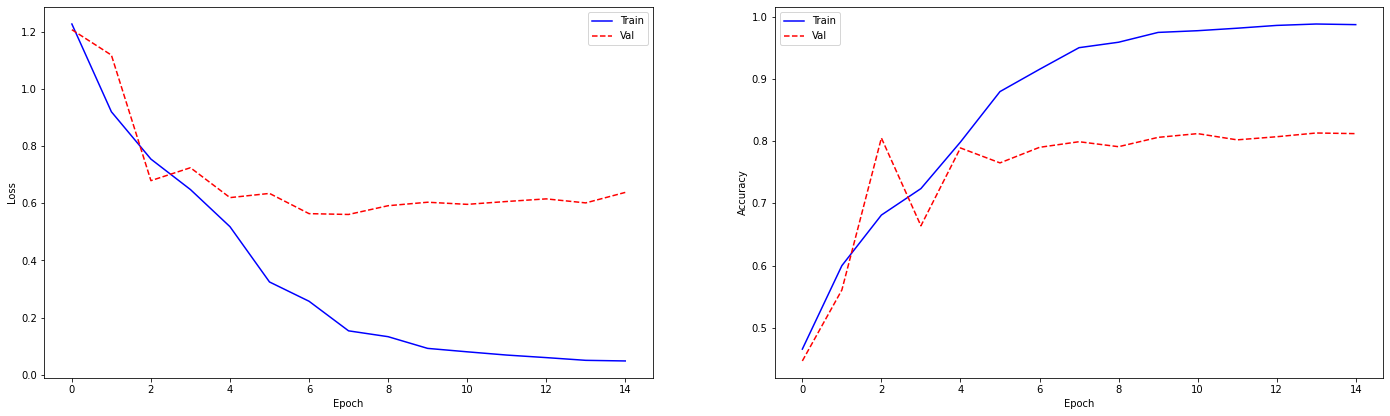

In [28]:
plot_metrics(nn_model_history)

In [29]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [30]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## 4.a) Alternate Model One

In [31]:
# Initialize the neural network model and get the training results for plotting graph
startTimeModule = datetime.now()
reset_random(seedNum)
nn_model_1 = create_nn_model(conv1_filters=256, conv2_filters=128, conv3_filters=64, conv1_dropout=0.25, conv2_dropout=0.25, conv3_dropout=0, dense_nodes=512, dense_dropout=0.25)
nn_model_history = nn_model_1.fit(
    training_generator,
    steps_per_epoch=len(training_generator),
	validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=EPOCH_NUMBER,
    callbacks=[learning_rate_reduction],
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/15
250/250 [==============================] - 12s 47ms/step - loss: 1.0368 - accuracy: 0.5450 - val_loss: 0.8103 - val_accuracy: 0.7330
Epoch 2/15
250/250 [==============================] - 12s 46ms/step - loss: 0.7193 - accuracy: 0.7057 - val_loss: 0.7344 - val_accuracy: 0.7610
Epoch 3/15
250/250 [==============================] - 12s 46ms/step - loss: 0.6054 - accuracy: 0.7688 - val_loss: 0.6385 - val_accuracy: 0.7890
Epoch 4/15
250/250 [==============================] - 12s 46ms/step - loss: 0.5462 - accuracy: 0.7903 - val_loss: 0.6265 - val_accuracy: 0.7870
Epoch 5/15
250/250 [==============================] - 11s 46ms/step - loss: 0.4803 - accuracy: 0.8173 - val_loss: 0.5595 - val_accuracy: 0.8190
Epoch 6/15
250/250 [==============================] - 12s 46ms/step - loss: 0.4199 - accuracy: 0.8487 - val_loss: 0.5414 - val_accuracy: 0.8210
Epoch 7/15
250/250 [==============================] - 11s 46ms/step - loss: 0.3728 - accuracy: 0.8648 - val_loss: 0.5116 - val_accuracy:

In [32]:
nn_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 256)     7168      
_________________________________________________________________
dropout_4 (Dropout)          (None, 150, 150, 256)     0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 128)       295040    
_________________________________________________________________
dropout_5 (Dropout)          (None, 75, 75, 128)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 38, 38, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 38, 38, 64)       

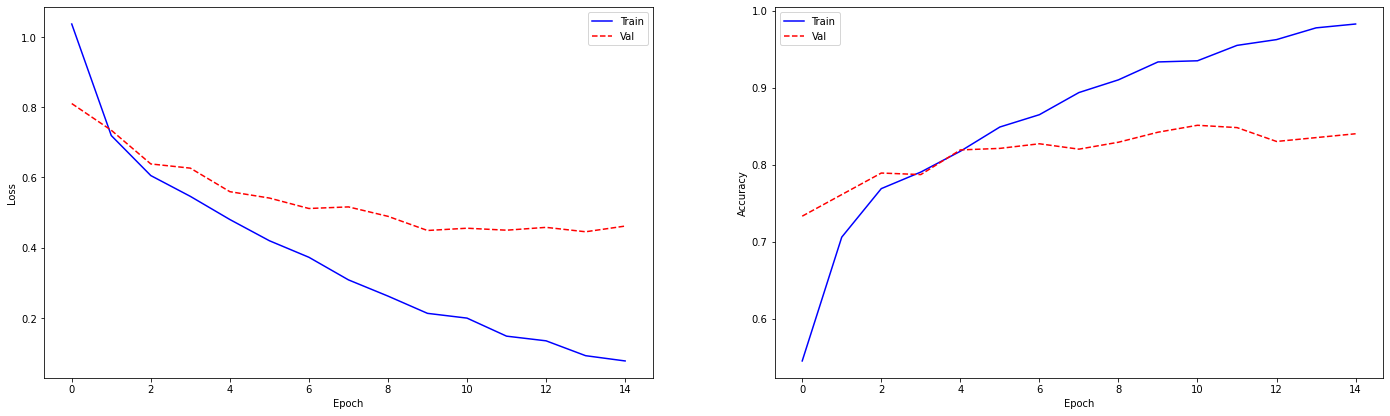

In [33]:
plot_metrics(nn_model_history)

In [34]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [35]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [36]:
final_model = nn_model_1

# Display a summary of the final model
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 256)     7168      
_________________________________________________________________
dropout_4 (Dropout)          (None, 150, 150, 256)     0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 128)       295040    
_________________________________________________________________
dropout_5 (Dropout)          (None, 75, 75, 128)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 38, 38, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 38, 38, 64)       

In [37]:
# Print the labels used for the modeling
print(validation_generator.class_indices)

{'01_TUMOR': 0, '02_STROMA': 1, '03_COMPLEX': 2, '04_LYMPHO': 3, '05_DEBRIS': 4, '06_MUCOSA': 5, '07_ADIPOSE': 6, '08_EMPTY': 7}


In [38]:
final_model.evaluate(validation_generator, verbose=1)

63/63 [==============================] - 1s 16ms/step - loss: 0.4616 - accuracy: 0.8400


[0.4616208076477051, 0.8399999737739563]

In [39]:
test_pred = final_model.predict(validation_generator)
test_predictions = np.argmax(test_pred, axis=-1)
test_original = validation_generator.labels
print('Accuracy Score:', accuracy_score(test_original, test_predictions))
print(confusion_matrix(test_original, test_predictions))
print(classification_report(test_original, test_predictions))

Accuracy Score: 0.84
[[120   1   2   0   0   2   0   0]
 [  0  90  24   0   8   3   0   0]
 [  4  11  92  13   0   5   0   0]
 [  3   0   3 116   0   3   0   0]
 [  1  26   4   1  89   3   1   0]
 [ 19   0   1   7   4  94   0   0]
 [  0   0   0   0   3   0 116   6]
 [  0   0   0   0   0   0   2 123]]
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       125
           1       0.70      0.72      0.71       125
           2       0.73      0.74      0.73       125
           3       0.85      0.93      0.89       125
           4       0.86      0.71      0.78       125
           5       0.85      0.75      0.80       125
           6       0.97      0.93      0.95       125
           7       0.95      0.98      0.97       125

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



In [40]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [41]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:05:45.058196
